In [1]:
from tqdm import tqdm
import mpramnist
from mpramnist.malinoisdataset import MalinoisDataset

import mpramnist.transforms as t
import mpramnist.target_transforms as t_t

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torchsummary import summary
import lightning.pytorch as pl
from lightning.pytorch import loggers as pl_loggers
from lightning.pytorch.callbacks import TQDMProgressBar
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

import tempfile
import hypertune
from collections import OrderedDict
import math
import os
import sys
import subprocess

/home/nios/miniconda3/envs/mpra/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
left_flank = MalinoisDataset.LEFT_FLANK
right_flank = MalinoisDataset.RIGHT_FLANK

In [3]:
BATCH_SIZE = 1076
NUM_WORKERS = 8

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
def shannon_entropy(x):
    p_c = nn.Softmax(dim=1)(x)    
    return torch.sum(- p_c * torch.log(p_c), axis=1)
def pearson_correlation(x, y):
    vx = x - torch.mean(x, dim=0)
    vy = y - torch.mean(y, dim=0)
    pearsons = torch.sum(vx * vy, dim=0) / (torch.sqrt(torch.sum(vx ** 2, dim=0)) * torch.sqrt(torch.sum(vy ** 2, dim=0)) + 1e-10)
    return pearsons, torch.mean(pearsons)
def _get_ranks(x):
    tmp = x.argsort(dim=0)
    ranks = torch.zeros_like(tmp)
    if len(x.shape) > 1:
        dims = x.shape[1]
        for dim in range(dims):
            ranks[tmp[:,dim], dim] = torch.arange(x.shape[0], layout=x.layout, device=x.device)
    else:
        ranks[tmp] = torch.arange(x.shape[0], layout=x.layout, device=x.device)
    return ranks
def spearman_correlation(x, y):
    x_rank = _get_ranks(x).float()
    y_rank = _get_ranks(y).float()
    return pearson_correlation(x_rank, y_rank)

def filter_state_dict(model, stashed_dict):
    results_dict = { 
        'filtered_state_dict': {},
        'passed_keys'  : [],
        'removed_keys' : [],
        'missing_keys' : [],
        'unloaded_keys': []
                   }
    old_dict = model.state_dict()

    for m_key, m_value in old_dict.items():
        try:
            
            if old_dict[m_key].shape == stashed_dict[m_key].shape:
                results_dict['filtered_state_dict'][m_key] = stashed_dict[m_key]
                results_dict['passed_keys'].append(m_key)
                print(f'Key {m_key} successfully matched', file=sys.stderr)
                
            else:
                check_str = 'Size mismatch for key: {}, expected size {}, got {}' \
                              .format(m_key, old_dict[m_key].shape, stashed_dict[m_key].shape)
                results_dict['removed_keys'].append(m_key)
                print(check_str, file=sys.stderr)
                
        except KeyError:
            results_dict['missing_keys'].append(m_key)
            print(f'Missing key in dict: {m_key}', file=sys.stderr)
            
    for m_key, m_value in stashed_dict.items():
        if m_key not in old_dict.keys():
            check_str = 'Skipped loading key: {} of size {}' \
                           .format(m_key, m_value.shape)
            results_dict['unloaded_keys'].append(m_key)
            print(check_str, file=sys.stderr)
            
    return results_dict

In [6]:
class L1KLmixed(nn.Module):
    """
    A custom loss module that combines L1 loss with Kullback-Leibler (KL) divergence loss.

    Args:
        reduction (str, optional): Specifies the reduction to apply to the losses. Default is 'mean'.
        alpha (float, optional): Scaling factor for the L1 loss term. Default is 1.0.
        beta (float, optional): Scaling factor for the KL divergence loss term. Default is 1.0.

    Attributes:
        reduction (str): The reduction method applied to the losses.
        alpha (float): Scaling factor for the L1 loss term.
        beta (float): Scaling factor for the KL divergence loss term.
        MSE (nn.L1Loss): The L1 loss function.
        KL (nn.KLDivLoss): The Kullback-Leibler divergence loss function.

    Methods:
        forward(preds, targets):
            Calculate the combined loss by combining L1 and KL divergence losses.

    Example:
        loss_fn = L1KLmixed()
        loss = loss_fn(predictions, targets)
    """
    
    def __init__(self, reduction='mean', alpha=1.0, beta=1.0):
        super().__init__()
        
        self.reduction = reduction
        self.alpha = alpha
        self.beta  = beta
        
        self.MSE = nn.L1Loss(reduction=reduction.replace('batch',''))
        self.KL  = nn.KLDivLoss(reduction=reduction, log_target=True)
        
    def forward(self, preds, targets):
        preds_log_prob  = preds   - torch.logsumexp(preds, dim=-1, keepdim=True)
        target_log_prob = targets - torch.logsumexp(targets, dim=-1, keepdim=True)
        
        MSE_loss = self.MSE(preds, targets)
        KL_loss  = self.KL(preds_log_prob, target_log_prob)
        
        combined_loss = MSE_loss.mul(self.alpha) + \
                        KL_loss.mul(self.beta)
        
        return combined_loss.div(self.alpha+self.beta)

In [7]:
class BranchedLinear(nn.Module):
    def __init__(self, in_features, hidden_group_size, out_group_size, 
                 n_branches=1, n_layers=1, 
                 activation='ReLU', dropout_p=0.5):
        super().__init__()
        
        self.in_features = in_features
        self.hidden_group_size = hidden_group_size
        self.out_group_size = out_group_size
        self.n_branches = n_branches
        self.n_layers   = n_layers
        
        self.branches = OrderedDict()
        
        self.nonlin  = getattr(nn, activation)()                               
        self.dropout = nn.Dropout(p=dropout_p)
        
        self.intake = RepeatLayer(1, n_branches)
        cur_size = in_features
        
        for i in range(n_layers):
            if i + 1 == n_layers:
                setattr(self, f'branched_layer_{i+1}',  GroupedLinear(cur_size, out_group_size, n_branches))
            else:
                setattr(self, f'branched_layer_{i+1}',  GroupedLinear(cur_size, hidden_group_size, n_branches))
            cur_size = hidden_group_size
            
    def forward(self, x):

        hook = self.intake(x)
        
        i = -1
        for i in range(self.n_layers-1):
            hook = getattr(self, f'branched_layer_{i+1}')(hook)
            hook = self.dropout( self.nonlin(hook) )
        hook = getattr(self, f'branched_layer_{i+2}')(hook)
            
        return hook

class RepeatLayer(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.args = args
        
    def forward(self, x):
        return x.repeat(*self.args)
        
class GroupedLinear(nn.Module):
    def __init__(self, in_group_size, out_group_size, groups):

        super().__init__()
        
        self.in_group_size = in_group_size
        self.out_group_size= out_group_size
        self.groups        = groups
        
        #initialize weights
        self.weight = torch.nn.Parameter(torch.zeros(groups, in_group_size, out_group_size))
        self.bias   = torch.nn.Parameter(torch.zeros(groups, 1, out_group_size))
        
        #change weights to kaiming
        self.reset_parameters(self.weight, self.bias)
        
    def reset_parameters(self, weights, bias):
        torch.nn.init.kaiming_uniform_(weights, a=math.sqrt(3))
        fan_in, _ = torch.nn.init._calculate_fan_in_and_fan_out(weights)
        bound = 1 / math.sqrt(fan_in)
        torch.nn.init.uniform_(bias, -bound, bound)
    
    def forward(self, x):
        reorg = x.permute(1,0).reshape(self.groups, self.in_group_size, -1).permute(0,2,1)
        hook  = torch.bmm(reorg, self.weight) + self.bias
        reorg = hook.permute(0,2,1).reshape(self.out_group_size*self.groups,-1).permute(1,0)
        
        return reorg
class LinearNorm(nn.Module):
    def __init__(self, in_features, out_features, bias=True, 
                 batch_norm=True, weight_norm=True):
        super(LinearNorm, self).__init__()
        self.linear  = nn.Linear(in_features, out_features, bias=True)
        if weight_norm:
            self.linear = nn.utils.weight_norm(self.linear)
        if batch_norm:
            self.bn_layer = nn.BatchNorm1d(out_features, eps=1e-05, momentum=0.1, 
                                           affine=True, track_running_stats=True)
    def forward(self, input):
        try:
            return self.bn_layer( self.linear( input ) )
        except AttributeError:
            return self.linear( input )
class Conv1dNorm(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, 
                 stride=1, padding=0, dilation=1, groups=1, 
                 bias=True, batch_norm=True, weight_norm=True):
        super(Conv1dNorm, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, 
                              stride, padding, dilation, groups, bias)
        if weight_norm:
            self.conv = nn.utils.weight_norm(self.conv)
        if batch_norm:
            self.bn_layer = nn.BatchNorm1d(out_channels, eps=1e-05, momentum=0.1, 
                                           affine=True, track_running_stats=True)
    def forward(self, input):
        try:
            return self.bn_layer( self.conv( input ) )
        except AttributeError:
            return self.conv( input )

def get_padding(kernel_size):
    """
    Calculate padding values for convolutional layers.

    Args:
        kernel_size (int): Size of the convolutional kernel.

    Returns:
        list: Padding values for left and right sides of the kernel.
    """
    left = (kernel_size - 1) // 2
    right= kernel_size - 1 - left
    return [ max(0,x) for x in [left,right] ]

In [8]:
class BassetBranched(pl.LightningModule):
    ######################
    # Model construction #
    ######################
    
    def __init__(self, input_len=600,
                 conv1_channels=300, conv1_kernel_size=19, 
                 conv2_channels=200, conv2_kernel_size=11, 
                 conv3_channels=200, conv3_kernel_size=7, 
                 n_linear_layers=2, linear_channels=1000, 
                 linear_activation='ReLU', linear_dropout_p=0.3, 
                 n_branched_layers=1, branched_channels=250, 
                 branched_activation='ReLU6', branched_dropout_p=0., 
                 n_outputs=280,
                 use_batch_norm=True, use_weight_norm=False, 
                 loss_criterion='L1KLmixed', loss_args={}):                                              
        super().__init__()        
        
        self.input_len         = input_len
        
        self.conv1_channels    = conv1_channels
        self.conv1_kernel_size = conv1_kernel_size
        self.conv1_pad = get_padding(conv1_kernel_size)
        
        self.conv2_channels    = conv2_channels
        self.conv2_kernel_size = conv2_kernel_size
        self.conv2_pad = get_padding(conv2_kernel_size)

        
        self.conv3_channels    = conv3_channels
        self.conv3_kernel_size = conv3_kernel_size
        self.conv3_pad = get_padding(conv3_kernel_size)
        
        self.n_linear_layers   = n_linear_layers
        self.linear_channels   = linear_channels
        self.linear_activation = linear_activation
        self.linear_dropout_p  = linear_dropout_p
        
        self.n_branched_layers = n_branched_layers
        self.branched_channels = branched_channels
        self.branched_activation = branched_activation
        self.branched_dropout_p= branched_dropout_p
        
        self.n_outputs         = n_outputs
        
        self.loss_criterion    = loss_criterion
        self.loss_args         = loss_args
        
        self.use_batch_norm    = use_batch_norm
        self.use_weight_norm   = use_weight_norm
        
        self.pad1  = nn.ConstantPad1d(self.conv1_pad, 0.)
        self.conv1 = Conv1dNorm(4, 
                                self.conv1_channels, self.conv1_kernel_size, 
                                stride=1, padding=0, dilation=1, groups=1, 
                                bias=True, 
                                batch_norm=self.use_batch_norm, 
                                weight_norm=self.use_weight_norm)
        self.pad2  = nn.ConstantPad1d(self.conv2_pad, 0.)
        self.conv2 = Conv1dNorm(self.conv1_channels, 
                                self.conv2_channels, self.conv2_kernel_size, 
                                stride=1, padding=0, dilation=1, groups=1, 
                                bias=True, 
                                batch_norm=self.use_batch_norm, 
                                weight_norm=self.use_weight_norm)
        self.pad3  = nn.ConstantPad1d(self.conv3_pad, 0.)
        self.conv3 = Conv1dNorm(self.conv2_channels, 
                                self.conv3_channels, self.conv3_kernel_size, 
                                stride=1, padding=0, dilation=1, groups=1, 
                                bias=True, 
                                batch_norm=self.use_batch_norm, 
                                weight_norm=self.use_weight_norm)
        
        self.pad4 = nn.ConstantPad1d((1,1), 0.)

        self.maxpool_3 = nn.MaxPool1d(3, padding=0)
        self.maxpool_4 = nn.MaxPool1d(4, padding=0)
        
        next_in_channels = self.conv3_channels * self.get_flatten_factor(self.input_len)
        
        for i in range(self.n_linear_layers):
            
            setattr(self, f'linear{i+1}', 
                    LinearNorm(next_in_channels, self.linear_channels, 
                               bias=True, 
                               batch_norm=self.use_batch_norm, 
                               weight_norm=self.use_weight_norm)
                   )
            next_in_channels = self.linear_channels

        self.branched = BranchedLinear(next_in_channels, self.branched_channels, 
                                       self.branched_channels, 
                                       self.n_outputs, self.n_branched_layers, 
                                       self.branched_activation, self.branched_dropout_p)
            
        self.output  = GroupedLinear(self.branched_channels, 1, self.n_outputs)
        
        self.nonlin  = getattr(nn, self.linear_activation)()                               
        
        self.dropout = nn.Dropout(p=self.linear_dropout_p)
        
        self.criterion = self.loss_criterion
    
    def get_flatten_factor(self, input_len):
        
        
        
        hook = input_len
        assert hook % 3 == 0
        hook = hook // 3
        assert hook % 4 == 0
        hook = hook // 4
        assert (hook + 2) % 4 == 0
        
        return (hook + 2) // 4
    
    ######################
    # Model computations #
    ######################
    
    def encode(self, x):
        hook = self.nonlin( self.conv1( self.pad1( x ) ) )
        hook = self.maxpool_3( hook )
        hook = self.nonlin( self.conv2( self.pad2( hook ) ) )
        hook = self.maxpool_4( hook )
        hook = self.nonlin( self.conv3( self.pad3( hook ) ) )
        hook = self.maxpool_4( self.pad4( hook ) )        
        hook = torch.flatten( hook, start_dim=1 )
        return hook
    
    def decode(self, x):
        hook = x
        for i in range(self.n_linear_layers):
            hook = self.dropout( 
                self.nonlin( 
                    getattr(self,f'linear{i+1}')(hook)
                )
            )
        hook = self.branched(hook)

        return hook
    
    def classify(self, x):
        output = self.output( x )
        return output
        
    def forward(self, x):
        encoded = self.encode(x)
        decoded = self.decode(encoded)
        output  = self.classify(decoded)
        return output

In [34]:
class CNNBasicTraining(pl.LightningModule):

    ####################
    # Standard methods #
    ####################
    
    def __init__(self, model, optimizer='Adam', amsgrad = False,
                          lr = 0.0032658700881052086,
                          eps = 1e-08,
                          weight_decay = 0.0003438210249762151,
                          beta1 = 0.9,
                          beta2 = 0.999, scheduler=None, 
                 scheduler_monitor=None, scheduler_interval='epoch', 
                 #optimizer_args=None, scheduler_args=None,
                T_0=4096, T_mult=1, eta_min=0.0, last_epoch=-1):
        super().__init__()
        self.model = model
        self.criterion = model.criterion
        self.amsgrad = amsgrad
        self.lr = lr
        self.eps = eps
        self.weight_decay = weight_decay
        self.beta1 = beta1
        self.beta2 = beta2
        self.T_0 = T_0 
        self.T_mult = T_mult
        self.eta_min = eta_min
        self.last_epoch = last_epoch
        
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.scheduler_monitor = scheduler_monitor
        self.scheduler_interval= scheduler_interval
        #self.optimizer_args = optimizer_args
        #self.scheduler_args = scheduler_args

        # 1. Create a list to hold the outputs of `*_step`
        self.arit_means = []
        self.harm_means = []
        self.epoch_pred = []
        self.epoch_label = []
        self.pearsons = []
        
    def forward(self, input):

        return self.model(input)

    ###################
    # Non-PTL methods #
    ###################
        
    def categorical_mse(self, x, y):
        return (x - y).pow(2).mean(dim=0)
        
    def aug_log(self, internal_metrics=None, external_metrics=None):
        if internal_metrics is not None:
            for my_key, my_value in internal_metrics.items():
                self.log(my_key, my_value)
                '''
                self.hpt.report_hyperparameter_tuning_metric(
                    hyperparameter_metric_tag=my_key,
                    metric_value=my_value,
                    global_step=self.global_step)
                    '''
                
        if external_metrics is not None:
            res_str = '|'
            for my_key, my_value in external_metrics.items():
                self.log(my_key, my_value)
                res_str += ' {}: {:.5f} |'.format(my_key, my_value)
                '''
                self.hpt.report_hyperparameter_tuning_metric(
                    hyperparameter_metric_tag=my_key,
                    metric_value=my_value,
                    global_step=self.global_step)
                    '''
            border = '-'*len(res_str)
            print("\n".join(['',border, res_str, border,'']))
        
        return None

    #############
    # PTL hooks #
    #############
        
    def configure_optimizers(self):
        
        #self.hpt = hypertune.HyperTune()
        params = [ x for x in self.parameters() if x.requires_grad ]
        print(f'Found {sum(p.numel() for p in params)} parameters')
        optim_class = getattr(torch.optim,self.optimizer)
        my_optimizer= optim_class(self.parameters(), lr=self.lr, 
                                  weight_decay=self.weight_decay, 
                                  betas=(self.beta1, self.beta2), 
                                  eps = self.eps,
                                  amsgrad=self.amsgrad) 
        if self.scheduler is not None:
            sch_dict = {
                'scheduler': getattr(torch.optim.lr_scheduler,
                                     self.scheduler)(my_optimizer, 
                                                     max_lr = self.lr,
                                                     three_phase=False, 
                                                     total_steps=self.trainer.estimated_stepping_batches,
                                                        pct_start=0.3,
                                                        cycle_momentum = False), 
                                                     '''
                                                     T_0=self.T_0, 
                                                     T_mult=self.T_mult, 
                                                     eta_min=self.eta_min,
                                                     last_epoch = self.last_epoch
                                                     '''
                                                    
                'interval': self.scheduler_interval, 
                'name': 'learning_rate'
            }
            if self.scheduler_monitor is not None:
                sch_dict['monitor'] = self.scheduler_monitor
            return [my_optimizer], [sch_dict]
        else:
            return my_optimizer
    
    def training_step(self, batch, batch_idx):
        
        x, y   = batch
        y_hat  = self(x)
        loss   = self.criterion(y_hat, y)
        self.log('train_loss', loss)
        return loss
        
    def validation_step(self, batch, batch_idx):
       
        x, y   = batch
        y_hat = self(x)
        loss   = self.criterion(y_hat, y)
        self.log('valid_loss', loss)
        metric = self.categorical_mse(y_hat, y)
        
        # 2. Add the outputs to the list
        self.arit_means.append(loss)
        self.harm_means.append(metric)
        self.epoch_pred.append(y_hat)
        self.epoch_label.append(y)
        
        return {'loss': loss, 'metric': metric, 'preds': y_hat, 'labels': y}

    def on_validation_epoch_end(self):
        '''
        arit_mean = torch.stack([ batch['loss'] for batch in val_step_outputs ], dim=0).mean()
        harm_mean = torch.stack([ batch['metric'] for batch in val_step_outputs ], dim=0).mean(dim=0).pow(-1).mean().pow(-1)
        epoch_preds = torch.cat([batch['preds'] for batch in val_step_outputs], dim=0)
        epoch_labels  = torch.cat([batch['labels'] for batch in val_step_outputs], dim=0)
        '''
        # 3. Do something with all outputs
        arit_mean = torch.stack( self.arit_means, dim=0).mean()
        harm_mean = torch.stack(self.harm_means, dim=0).mean(dim=0).pow(-1).mean().pow(-1)
        epoch_preds = torch.cat(self.epoch_pred, dim=0)
        epoch_labels  = torch.cat(self.epoch_label, dim=0)
        pearson, mean_pearson = pearson_correlation(epoch_preds, epoch_labels)
        spearman, mean_spearman = spearman_correlation(epoch_preds, epoch_labels)
        shannon_pred, shannon_label = shannon_entropy(epoch_preds), shannon_entropy(epoch_labels)
        specificity_spearman, specificity_mean_spearman = spearman_correlation(shannon_pred, shannon_label)
        self.aug_log(external_metrics={
            'current_epoch': self.current_epoch, 
            'arithmetic_mean_loss': arit_mean,
            'harmonic_mean_loss': harm_mean,
            'prediction_mean_pearson': mean_pearson.item(),
            'prediction_mean_spearman': mean_spearman.item(),
            'entropy_spearman': specificity_mean_spearman.item()
        })

        return None
    
    def test_step(self, batch, batch_idx):
       
        x, y = batch
        y_pred = self(x)
        loss = self.criterion(y_pred, y)
        self.log('test_loss', loss)  
        pearson, mean_pearson = pearson_correlation(y_pred, y)
        self.log("test_pearson", mean_pearson)
        
class CNNTransferLearning(CNNBasicTraining):
    
    ####################
    # Standard methods #
    ####################
    
    def __init__(self, model, parent_weights, frozen_epochs=0, 
                 optimizer='Adam', amsgrad = True,
                          lr = 0.0032658700881052086,
                          eps = 1e-08,
                          weight_decay = 0.0003438210249762151,
                          beta1 = 0.8661062881299633,
                          beta2 = 0.879223105336538, scheduler=None, 
                 scheduler_monitor=None, scheduler_interval='epoch', 
                 #optimizer_args=None, scheduler_args=None
                T_0=4096, T_mult=1, eta_min=0.0, last_epoch=-1):
        
        super().__init__(model, optimizer, amsgrad, lr, eps, weight_decay, beta1, beta2,
                         scheduler, scheduler_monitor, 
                         scheduler_interval, 
                         #optimizer_args, scheduler_args,
                         T_0, T_mult, eta_min, last_epoch)
        
        self.parent_weights = parent_weights
        self.frozen_epochs  = frozen_epochs
        
    ###################
    # Non-PTL methods #
    ###################
        '''
    def attach_parent_weights(self, my_weights):

        parent_state_dict = torch.load(my_weights)
        if 'model_state_dict' in parent_state_dict.keys():
            parent_state_dict = parent_state_dict['model_state_dict']
            
        mod_state_dict = filter_state_dict(self.model, parent_state_dict)
        self.model.load_state_dict( mod_state_dict['filtered_state_dict'], strict=False )
        return mod_state_dict['passed_keys']
    
    #############
    # PTL hooks #
    #############
        
    def setup(self, stage='training'):

        with tempfile.TemporaryDirectory() as tmpdirname:
            if 'tar.gz' in self.parent_weights:
                utils.unpack_artifact(self.parent_weights, tmpdirname)
                old_model = utils.model_fn(os.path.join( tmpdirname, 'artifacts' ))
                the_weights = os.path.join( tmpdirname, 'stash_dict.pkl' )
                torch.save(old_model.state_dict(), the_weights)
            elif 'gs://' in self.parent_weights:
                subprocess.call(['gsutil','cp',self.parent_weights,tmpdirname])
                the_weights = os.path.join( tmpdirname, os.path.basename(self.parent_weights) )
            else:
                the_weights = self.parent_weights
            self.transferred_keys = self.attach_parent_weights(the_weights)
        
    def on_train_epoch_start(self):
        print(f'starting epoch {self.current_epoch}')
        for name, p in self.named_parameters():
            if self.current_epoch < self.frozen_epochs:
                if name in self.transferred_keys:
                    p.requires_grad = False
                else:
                    p.requires_grad = True
            else:
                p.requires_grad = True
                '''

# without t.Reverse(0.5), but with reverse augs, origin data

In [10]:
# preprocessing
train_transform = t.Compose([
    t.AddFlanks(left_flank, right_flank),
    t.CenterCrop(600),
    #t.Reverse(0.5),
    t.Seq2Tensor()
])
val_test_transform = t.Compose([
    t.AddFlanks(left_flank, right_flank),
    t.CenterCrop(600),
    t.Seq2Tensor()
])

target_transform = t_t.Compose([
    t_t.Normalize(mean = 0.500, std = 1.059) # original for Malinois 
])
activity_columns = ['HepG2','SKNSH', "K562"]
#stderr = ['lfcSE_k562', 'lfcSE_hepg2', 'lfcSE_sknsh']
stderr = ['K562_lfcSE', 'HepG2_lfcSE', 'SKNSH_lfcSE']
#seq = "nt_sequence"
seq = "sequence"
# load the data
train_dataset = MalinoisDataset(activity_columns = activity_columns, 
                              #split = [1, 2, 3, 4, 5, 6, 8, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 22, "Y"], 
                                split = "train",
                              filtration = "original",
                                duplication_cutoff = 0.5,
                                use_reverse_complement = True,
                                stderr_columns = stderr,
                                sequence_column = seq,
                              transform = train_transform,
                               target_transform = target_transform) 

val_dataset = MalinoisDataset(activity_columns = activity_columns, 
                              #split = [7, 13], 
                              split = "val",
                              filtration = "original",
                              sequence_column = seq,
                              stderr_columns = stderr,
                              transform = val_test_transform,
                             target_transform = target_transform) 

test_dataset = MalinoisDataset(activity_columns = activity_columns, 
                              #split = [9, 21, "X"],
                               split = "test",
                              filtration = "original",
                               sequence_column = seq,
                               stderr_columns = stderr,
                              transform = val_test_transform,
                              target_transform = target_transform)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)

In [11]:
print(train_dataset)
print("="*50)
print(val_dataset)
print("="*50)
print(test_dataset)

Dataset MalinoisDataset of size 1864208 (MpraDaraset)
    Number of datapoints: 1864208
    Default split folds: {'train': '1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 20, 22, Y', 'val': '19, 21, X', 'test': '7, 13'}
    Used split fold: ['1', '2', '3', '4', '5', '6', '8', '9', '10', '11', '12', '14', '15', '16', '17', '18', '20', '22', 'Y']
    Scalar features: {}
    Vector features: {}
    Cell types: ['HepG2', 'K562', 'SKNSH']
    Сell type used: ['HepG2_log2FC', 'SKNSH_log2FC', 'K562_log2FC']
    Target columns that can be used: {'K562_log2FC', 'HepG2_log2FC', 'SKNSH_log2FC'}
    Number of channels: 4
    Sequence size: 600
    Number of samples: {'train': 668946, 'val': 62406, 'test': 66712}
    Description: MalinoisDataset is based on 
Dataset MalinoisDataset of size 58810 (MpraDaraset)
    Number of datapoints: 58810
    Default split folds: {'train': '1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 20, 22, Y', 'val': '19, 21, X', 'test': '7, 13'}
    Used s

In [13]:
model = BassetBranched(linear_dropout_p=0.11625456877954289,
                      branched_activation='ReLU', branched_channels=140,
                      branched_dropout_p=0.5757068086404574, 
                       n_outputs=len(train_dataset[0][1]),
                      n_linear_layers=1, n_branched_layers=3, use_batch_norm=True,
                      loss_criterion=L1KLmixed(beta=5.0, reduction='mean'))
seq_model = CNNTransferLearning(model = model,
    parent_weights = "gs://tewhey-public-data/CODA_resources/my-model.epoch_5-step_19885.pkl",
                       frozen_epochs = 0,
                          optimizer = "Adam",
                          scheduler="CosineAnnealingWarmRestarts",
                          scheduler_interval="step")

callback_topmodel = pl.callbacks.ModelCheckpoint(monitor="prediction_mean_pearson",
                                                 save_top_k=1,
                                                 dirpath="./Malinois",
                                                 filename="Malinois_max")
callback_es = pl.callbacks.early_stopping.EarlyStopping(monitor='prediction_mean_pearson', 
                                                        patience=30)

logger = pl_loggers.TensorBoardLogger("./logs_Malinois", name = "Malinois_example")

# Initialize a trainer
trainer = pl.Trainer(
    accelerator='gpu', 
    devices=[0], 
    min_epochs=60, 
    max_epochs=200,
    precision=16,
    enable_progress_bar = False,
    callbacks=[
        #TQDMProgressBar(refresh_rate=50), 
        callback_es, 
        #callback_topmodel
    ],
    logger = logger
)

# Train the model
trainer.fit(seq_model,
            train_dataloaders=train_loader,
            val_dataloaders=val_loader)
trainer.test(seq_model, dataloaders=test_loader)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | model     | BassetBranched | 4.1 M  | train
1 | criterion | L1KLmixed      | 0      | train
-----------------------------------------------------
4.1 M     Trainable params
0         Non-trainable params
4.1 M     Total params
16.429    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Found 4107183 parameters

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
| current_epoch: 0.00000 | arithmetic_mean_loss: 0.14111 | harmonic_mean_loss: 1.28775 | prediction_mean_pearson: -0.00475 | prediction_mean_spearman: -0.02725 | entropy_spearman: 0.07296 |
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
| current_epoch: 0.00000 | arithmetic_mean_loss: 0.12353 | harmonic_mean_loss: 0.81533 | prediction_mean_pearson: 0.73623 | prediction_mean_spearman: 0.64304 | entropy_spearman: 0.25231 |
--------------------------

Trainer was signaled to stop but the required `min_epochs=60` or `min_steps=None` has not been met. Training will continue...



--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
| current_epoch: 31.00000 | arithmetic_mean_loss: 0.09814 | harmonic_mean_loss: 0.55455 | prediction_mean_pearson: 0.81927 | prediction_mean_spearman: 0.70069 | entropy_spearman: 0.42537 |
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
| current_epoch: 32.00000 | arithmetic_mean_loss: 0.09789 | harmonic_mean_loss: 0.55180 | prediction_mean_pearson: 0.82016 | prediction_mean_spearman: 0.70218 | entropy_spearman: 0.42703 |
----------------------------------------------------

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.08871891349554062
      test_pearson          0.7482768297195435
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.08871891349554062, 'test_pearson': 0.7482768297195435}]

# Use MPRA_ALL_HD_v2 with use_reverse_complement = True and without t.Reverse(0.5)

In [10]:
# preprocessing
train_transform = t.Compose([
    t.AddFlanks(left_flank, right_flank),
    t.CenterCrop(600),
    #t.Reverse(0.5),
    t.Seq2Tensor()
])
val_test_transform = t.Compose([
    t.AddFlanks(left_flank, right_flank),
    t.CenterCrop(600),
    t.Seq2Tensor()
])

target_transform = t_t.Compose([
    t_t.Normalize(mean = 0.500, std = 1.059) # original for Malinois 
])
activity_columns = ['HepG2','SKNSH', "K562"]
stderr = ['lfcSE_k562', 'lfcSE_hepg2', 'lfcSE_sknsh']
#stderr = ['K562_lfcSE', 'HepG2_lfcSE', 'SKNSH_lfcSE']
seq = "nt_sequence"
#seq = "sequence"
# load the data
train_dataset = MalinoisDataset(activity_columns = activity_columns, 
                              #split = [1, 2, 3, 4, 5, 6, 8, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 22, "Y"], 
                                split = "train",
                              filtration = "original",
                                duplication_cutoff = 0.5,
                                use_reverse_complement = True,
                                stderr_columns = stderr,
                                sequence_column = seq,
                              transform = train_transform,
                               target_transform = target_transform) 

val_dataset = MalinoisDataset(activity_columns = activity_columns, 
                              #split = [7, 13], 
                              split = "val",
                              filtration = "original",
                              sequence_column = seq,
                              stderr_columns = stderr,
                              transform = val_test_transform,
                             target_transform = target_transform) 

test_dataset = MalinoisDataset(activity_columns = activity_columns, 
                              #split = [9, 21, "X"],
                               split = "test",
                              filtration = "original",
                               sequence_column = seq,
                               stderr_columns = stderr,
                              transform = val_test_transform,
                              target_transform = target_transform)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)

In [11]:
print(train_dataset)
print("="*50)
print(val_dataset)
print("="*50)
print(test_dataset)

Dataset MalinoisDataset of size 1666532 (MpraDaraset)
    Number of datapoints: 1666532
    Default split folds: {'train': '1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 20, 22, Y', 'val': '19, 21, X', 'test': '7, 13'}
    Used split fold: ['1', '2', '3', '4', '5', '6', '8', '9', '10', '11', '12', '14', '15', '16', '17', '18', '20', '22', 'Y']
    Scalar features: {}
    Vector features: {}
    Cell types: ['HepG2', 'K562', 'SKNSH']
    Сell type used: ['HepG2_mean', 'SKNSH_mean', 'K562_mean']
    Target columns that can be used: {'HepG2_log2FC', 'K562_log2FC', 'SKNSH_log2FC'}
    Number of channels: 4
    Sequence size: 600
    Number of samples: {'train': 668946, 'val': 62406, 'test': 66712}
    Description: MalinoisDataset is based on 
Dataset MalinoisDataset of size 51991 (MpraDaraset)
    Number of datapoints: 51991
    Default split folds: {'train': '1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 20, 22, Y', 'val': '19, 21, X', 'test': '7, 13'}
    Used split f

In [12]:
model = BassetBranched(linear_dropout_p=0.11625456877954289,
                      branched_activation='ReLU', branched_channels=140,
                      branched_dropout_p=0.5757068086404574, 
                       n_outputs=len(train_dataset[0][1]),
                      n_linear_layers=1, n_branched_layers=3, use_batch_norm=True,
                      loss_criterion=L1KLmixed(beta=5.0, reduction='mean'))
seq_model = CNNTransferLearning(model = model,
    parent_weights = "gs://tewhey-public-data/CODA_resources/my-model.epoch_5-step_19885.pkl",
                       frozen_epochs = 0,
                          optimizer = "Adam",
                          scheduler="CosineAnnealingWarmRestarts",
                          scheduler_interval="step")

callback_topmodel = pl.callbacks.ModelCheckpoint(monitor="prediction_mean_pearson",
                                                 save_top_k=1,
                                                 dirpath="./Malinois",
                                                 filename="Malinois_max")
callback_es = pl.callbacks.early_stopping.EarlyStopping(monitor='prediction_mean_pearson', 
                                                        patience=30)

logger = pl_loggers.TensorBoardLogger("./logs_Malinois", name = "Malinois_MPRA_ALL_HD_v2")

# Initialize a trainer
trainer = pl.Trainer(
    accelerator='gpu', 
    devices=[0], 
    min_epochs=60, 
    max_epochs=200,
    precision=16,
    enable_progress_bar = False,
    callbacks=[
        #TQDMProgressBar(refresh_rate=50), 
        callback_es, 
        #callback_topmodel
    ],
    logger = logger
)

# Train the model
trainer.fit(seq_model,
            train_dataloaders=train_loader,
            val_dataloaders=val_loader)
trainer.test(seq_model, dataloaders=test_loader)

/home/nios/miniconda3/envs/mpra/lib/python3.12/site-packages/lightning/fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | model     | BassetBranched | 4.1 M  | train
1 | criterion | L1KLmixed      | 0      | train
---------

Found 4107183 parameters


/home/nios/miniconda3/envs/mpra/lib/python3.12/site-packages/torch/nn/functional.py:2994: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(



----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
| current_epoch: 0.00000 | arithmetic_mean_loss: 0.13618 | harmonic_mean_loss: 1.21210 | prediction_mean_pearson: -0.01456 | prediction_mean_spearman: -0.00196 | entropy_spearman: -0.01279 |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
| current_epoch: 0.00000 | arithmetic_mean_loss: 0.12098 | harmonic_mean_loss: 0.81087 | prediction_mean_pearson: 0.72466 | prediction_mean_spearman: 0.61541 | entropy_spearman: 0.21917 |
------------------------------------------------

Trainer was signaled to stop but the required `min_epochs=60` or `min_steps=None` has not been met. Training will continue...



--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
| current_epoch: 31.00000 | arithmetic_mean_loss: 0.09822 | harmonic_mean_loss: 0.55736 | prediction_mean_pearson: 0.81221 | prediction_mean_spearman: 0.70423 | entropy_spearman: 0.42597 |
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
| current_epoch: 32.00000 | arithmetic_mean_loss: 0.09822 | harmonic_mean_loss: 0.55580 | prediction_mean_pearson: 0.81270 | prediction_mean_spearman: 0.70444 | entropy_spearman: 0.42555 |
----------------------------------------------------

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.08264666050672531
      test_pearson          0.7583016157150269
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.08264666050672531, 'test_pearson': 0.7583016157150269}]

# use t.Reverse(0.5) without reverse augs, original data 60 epochs

In [14]:
# preprocessing
train_transform = t.Compose([
    t.AddFlanks(left_flank, right_flank),
    t.CenterCrop(600),
    t.Reverse(0.5),
    t.Seq2Tensor()
])
val_test_transform = t.Compose([
    t.AddFlanks(left_flank, right_flank),
    t.CenterCrop(600),
    t.Seq2Tensor()
])

target_transform = t_t.Compose([
    #t_t.Normalize(mean = 0.500, std = 1.059) # original for Malinois 
])
activity_columns = ['HepG2','SKNSH', "K562"]
#stderr = ['lfcSE_k562', 'lfcSE_hepg2', 'lfcSE_sknsh']
stderr = ['K562_lfcSE', 'HepG2_lfcSE', 'SKNSH_lfcSE']
#seq = "nt_sequence"
seq = "sequence"
# load the data
train_dataset = MalinoisDataset(activity_columns = activity_columns, 
                              #split = [1, 2, 3, 4, 5, 6, 8, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 22, "Y"], 
                                split = "train",
                              filtration = "original",
                                duplication_cutoff = 0.5,
                                #use_reverse_complement = True,
                                stderr_columns = stderr,
                                sequence_column = seq,
                              transform = train_transform,
                               target_transform = target_transform) 

val_dataset = MalinoisDataset(activity_columns = activity_columns, 
                              #split = [7, 13], 
                              split = "val",
                              filtration = "original",
                              sequence_column = seq,
                              stderr_columns = stderr,
                              transform = val_test_transform,
                             target_transform = target_transform) 

test_dataset = MalinoisDataset(activity_columns = activity_columns, 
                              #split = [9, 21, "X"],
                               split = "test",
                              filtration = "original",
                               sequence_column = seq,
                               stderr_columns = stderr,
                              transform = val_test_transform,
                              target_transform = target_transform)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)

In [15]:
print(train_dataset)
print("="*50)
print(val_dataset)
print("="*50)
print(test_dataset)

Dataset MalinoisDataset of size 932104 (MpraDaraset)
    Number of datapoints: 932104
    Default split folds: {'train': '1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 20, 22, Y', 'val': '19, 21, X', 'test': '7, 13'}
    Used split fold: ['1', '2', '3', '4', '5', '6', '8', '9', '10', '11', '12', '14', '15', '16', '17', '18', '20', '22', 'Y']
    Scalar features: {}
    Vector features: {}
    Cell types: ['HepG2', 'K562', 'SKNSH']
    Сell type used: ['HepG2_log2FC', 'SKNSH_log2FC', 'K562_log2FC']
    Target columns that can be used: {'K562_log2FC', 'HepG2_log2FC', 'SKNSH_log2FC'}
    Number of channels: 4
    Sequence size: 600
    Number of samples: {'train': 668946, 'val': 62406, 'test': 66712}
    Description: MalinoisDataset is based on 
Dataset MalinoisDataset of size 58810 (MpraDaraset)
    Number of datapoints: 58810
    Default split folds: {'train': '1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 20, 22, Y', 'val': '19, 21, X', 'test': '7, 13'}
    Used spl

In [12]:
model = BassetBranched(linear_dropout_p=0.11625456877954289,
                      branched_activation='ReLU', branched_channels=140,
                      branched_dropout_p=0.5757068086404574, 
                       n_outputs=len(train_dataset[0][1]),
                      n_linear_layers=1, n_branched_layers=3, use_batch_norm=True,
                      loss_criterion=L1KLmixed(beta=5.0, reduction='mean'))
seq_model = CNNTransferLearning(model = model,
    parent_weights = "gs://tewhey-public-data/CODA_resources/my-model.epoch_5-step_19885.pkl",
                       frozen_epochs = 0,
                          optimizer = "Adam",
                          scheduler="CosineAnnealingWarmRestarts",
                          scheduler_interval="step")

callback_topmodel = pl.callbacks.ModelCheckpoint(monitor="prediction_mean_pearson",
                                                 save_top_k=1,
                                                 dirpath="./Malinois",
                                                 filename="Malinois_max")
callback_es = pl.callbacks.early_stopping.EarlyStopping(monitor='prediction_mean_pearson', 
                                                        patience=30)

logger = pl_loggers.TensorBoardLogger("./logs_Malinois", name = "Malinois_without_rev_augs_with_use_t.Revese(0.5)")

# Initialize a trainer
trainer = pl.Trainer(
    accelerator='gpu', 
    devices=[0], 
    min_epochs=60, 
    max_epochs=200,
    precision=16,
    enable_progress_bar = False,
    callbacks=[
        #TQDMProgressBar(refresh_rate=50), 
        callback_es, 
        #callback_topmodel
    ],
    logger = logger
)

# Train the model
trainer.fit(seq_model,
            train_dataloaders=train_loader,
            val_dataloaders=val_loader)
trainer.test(seq_model, dataloaders=test_loader)

/home/nios/miniconda3/envs/mpra/lib/python3.12/site-packages/lightning/fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | model     | BassetBranched | 4.1 M  | train
1 | criterion | L1KLmixed      | 0      | train
---------

Found 4107183 parameters


/home/nios/miniconda3/envs/mpra/lib/python3.12/site-packages/torch/nn/functional.py:2994: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(



---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
| current_epoch: 0.00000 | arithmetic_mean_loss: 0.14147 | harmonic_mean_loss: 1.28705 | prediction_mean_pearson: -0.01738 | prediction_mean_spearman: -0.05536 | entropy_spearman: 0.06121 |
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
| current_epoch: 0.00000 | arithmetic_mean_loss: 0.13075 | harmonic_mean_loss: 1.21925 | prediction_mean_pearson: 0.64533 | prediction_mean_spearman: 0.54006 | entropy_spearman: 0.25293 |
---------------------------------------------------

Trainer was signaled to stop but the required `min_epochs=60` or `min_steps=None` has not been met. Training will continue...



--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
| current_epoch: 31.00000 | arithmetic_mean_loss: 0.09256 | harmonic_mean_loss: 0.51905 | prediction_mean_pearson: 0.83063 | prediction_mean_spearman: 0.75361 | entropy_spearman: 0.43926 |
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
| current_epoch: 32.00000 | arithmetic_mean_loss: 0.09217 | harmonic_mean_loss: 0.51502 | prediction_mean_pearson: 0.83203 | prediction_mean_spearman: 0.75552 | entropy_spearman: 0.44184 |
----------------------------------------------------

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.07348258048295975
      test_pearson          0.8333613276481628
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.07348258048295975, 'test_pearson': 0.8333613276481628}]

### 0.83 the best result

# train for 200 epochs

In [ ]:
model = BassetBranched(linear_dropout_p=0.11625456877954289,
                      branched_activation='ReLU', branched_channels=140,
                      branched_dropout_p=0.5757068086404574, 
                       n_outputs=len(train_dataset[0][1]),
                      n_linear_layers=1, n_branched_layers=3, use_batch_norm=True,
                      loss_criterion=L1KLmixed(beta=5.0, reduction='mean'))
seq_model = CNNTransferLearning(model = model,
    parent_weights = "gs://tewhey-public-data/CODA_resources/my-model.epoch_5-step_19885.pkl",
                       frozen_epochs = 0,
                          optimizer = "Adam",
                          scheduler="CosineAnnealingWarmRestarts",
                          scheduler_interval="step")

callback_topmodel = pl.callbacks.ModelCheckpoint(monitor="prediction_mean_pearson",
                                                 save_top_k=1,
                                                 dirpath="./Malinois",
                                                 filename="Malinois_max")
callback_es = pl.callbacks.early_stopping.EarlyStopping(monitor='prediction_mean_pearson', 
                                                        patience=30)

logger = pl_loggers.TensorBoardLogger("./logs_Malinois", name = "Malinois_without_rev_augs_with_use_t.Revese(0.5)_200epochs")

# Initialize a trainer
trainer = pl.Trainer(
    accelerator='gpu', 
    devices=[0], 
    min_epochs=60, 
    max_epochs=200,
    precision=16,
    enable_progress_bar = False,
    callbacks=[
        #TQDMProgressBar(refresh_rate=50), 
        #callback_es, 
        #callback_topmodel
    ],
    logger = logger
)

# Train the model
trainer.fit(seq_model,
            train_dataloaders=train_loader,
            val_dataloaders=val_loader)
trainer.test(seq_model, dataloaders=test_loader)

/home/nios/miniconda3/envs/mpra/lib/python3.12/site-packages/lightning/fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | model     | BassetBranched | 4.1 M  | train
1 | criterion | L1KLmixed      | 0      | train
-----------------------------------------------------
4.1 M     Trainable params
0         Non-trainable params
4.1 M     Total params
16.429    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Found 4107183 parameters

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
| current_epoch: 0.00000 | arithmetic_mean_loss: 0.15307 | harmonic_mean_loss: 1.77294 | prediction_mean_pearson: 0.00341 | prediction_mean_spearman: 0.00123 | entropy_spearman: 0.07261 |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------



/home/nios/miniconda3/envs/mpra/lib/python3.12/site-packages/torch/nn/functional.py:2994: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(



-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
| current_epoch: 0.00000 | arithmetic_mean_loss: 0.12907 | harmonic_mean_loss: 1.03301 | prediction_mean_pearson: 0.67402 | prediction_mean_spearman: 0.57775 | entropy_spearman: 0.23495 |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
| current_epoch: 1.00000 | arithmetic_mean_loss: 0.12100 | harmonic_mean_loss: 0.89690 | prediction_mean_pearson: 0.72479 | prediction_mean_spearman: 0.64118 | entropy_spearman: 0.31507 |
---------------------------------------------------------

# train with RevComp dataset

In [10]:
# preprocessing
train_transform = t.Compose([
    t.AddFlanks(left_flank, right_flank),
    t.CenterCrop(600),
    #t.Reverse(0.5),
    t.Seq2Tensor()
])
val_test_transform = t.Compose([
    t.AddFlanks(left_flank, right_flank),
    t.CenterCrop(600),
    t.Seq2Tensor()
])

target_transform = t_t.Compose([
    #t_t.Normalize(mean = 0.500, std = 1.059) # original for Malinois 
])
activity_columns = ['HepG2','SKNSH', "K562"]
#stderr = ['lfcSE_k562', 'lfcSE_hepg2', 'lfcSE_sknsh']
stderr = ['K562_lfcSE', 'HepG2_lfcSE', 'SKNSH_lfcSE']
#seq = "nt_sequence"
seq = "sequence"
# load the data
train_dataset = MalinoisDataset(activity_columns = activity_columns, 
                              #split = [1, 2, 3, 4, 5, 6, 8, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 22, "Y"], 
                                split = "train",
                              filtration = "original",
                                duplication_cutoff = 0.5,
                                use_reverse_complement = True,
                                stderr_columns = stderr,
                                sequence_column = seq,
                              transform = train_transform,
                               target_transform = target_transform) 

val_dataset = MalinoisDataset(activity_columns = activity_columns, 
                              #split = [7, 13], 
                              split = "val",
                              filtration = "original",
                              sequence_column = seq,
                              stderr_columns = stderr,
                              transform = val_test_transform,
                             target_transform = target_transform) 

test_dataset = MalinoisDataset(activity_columns = activity_columns, 
                              #split = [9, 21, "X"],
                               split = "test",
                              filtration = "original",
                               sequence_column = seq,
                               stderr_columns = stderr,
                              transform = val_test_transform,
                              target_transform = target_transform)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)

In [11]:
print(train_dataset)
print("="*50)
print(val_dataset)
print("="*50)
print(test_dataset)

Dataset MalinoisDataset of size 1864176 (MpraDaraset)
    Number of datapoints: 1864176
    Default split folds: {'train': '1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 20, 22, Y', 'val': '19, 21, X', 'test': '7, 13'}
    Used split fold: ['1', '2', '3', '4', '5', '6', '8', '9', '10', '11', '12', '14', '15', '16', '17', '18', '20', '22', 'Y']
    Scalar features: {}
    Vector features: {}
    Cell types: ['HepG2', 'K562', 'SKNSH']
    Сell type used: ['HepG2_log2FC', 'SKNSH_log2FC', 'K562_log2FC']
    Target columns that can be used: {'SKNSH_log2FC', 'K562_log2FC', 'HepG2_log2FC'}
    Number of channels: 4
    Sequence size: 600
    Number of samples: {'train': 668946, 'val': 62406, 'test': 66712}
    Description: MalinoisDataset is based on 
Dataset MalinoisDataset of size 58809 (MpraDaraset)
    Number of datapoints: 58809
    Default split folds: {'train': '1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 20, 22, Y', 'val': '19, 21, X', 'test': '7, 13'}
    Used s

In [ ]:
model = BassetBranched(linear_dropout_p=0.11625456877954289,
                      branched_activation='ReLU', branched_channels=140,
                      branched_dropout_p=0.5757068086404574, 
                       n_outputs=len(train_dataset[0][1]),
                      n_linear_layers=1, n_branched_layers=3, use_batch_norm=True,
                      loss_criterion=L1KLmixed(beta=5.0, reduction='mean'))
seq_model = CNNTransferLearning(model = model,
                                lr = 3e-4, weight_decay = 0.01,
    parent_weights = "gs://tewhey-public-data/CODA_resources/my-model.epoch_5-step_19885.pkl",
                       frozen_epochs = 0,
                          optimizer = "AdamW",
                          scheduler="OneCycleLR",
                          scheduler_interval="step")

callback_topmodel = pl.callbacks.ModelCheckpoint(monitor="prediction_mean_pearson",
                                                 save_top_k=1,
                                                 dirpath="./Malinois",
                                                 filename="Malinois_max",
                                                mode = "max")
callback_es = pl.callbacks.early_stopping.EarlyStopping(monitor='prediction_mean_pearson', 
                                                        patience=30)

logger = pl_loggers.TensorBoardLogger("./logs_Malinois", name = "Malinois_without_rev_augs_with_use_t.Revese(0.5)_200epochs")

# Initialize a trainer
trainer = pl.Trainer(
    accelerator='gpu', 
    devices=[0], 
    min_epochs=60, 
    max_epochs=200,
    precision=16,
    enable_progress_bar = False,
    callbacks=[
        #TQDMProgressBar(refresh_rate=50), 
        callback_es, 
        #callback_topmodel
    ],
    #logger = logger
)

# Train the model
trainer.fit(seq_model,
            train_dataloaders=train_loader,
            val_dataloaders=val_loader)
trainer.test(seq_model, dataloaders=test_loader)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loading `train_dataloader` to estimate number of stepping batches.


Found 4107183 parameters



  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | model     | BassetBranched | 4.1 M  | train
1 | criterion | L1KLmixed      | 0      | train
-----------------------------------------------------
4.1 M     Trainable params
0         Non-trainable params
4.1 M     Total params
16.429    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode



---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
| current_epoch: 0.00000 | arithmetic_mean_loss: 0.14944 | harmonic_mean_loss: 1.70781 | prediction_mean_pearson: -0.01965 | prediction_mean_spearman: -0.04015 | entropy_spearman: 0.02950 |
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
| current_epoch: 0.00000 | arithmetic_mean_loss: 0.14564 | harmonic_mean_loss: 1.30968 | prediction_mean_pearson: 0.57799 | prediction_mean_spearman: 0.46093 | entropy_spearman: 0.10416 |
---------------------------------------------------

# Lr finder

In [10]:
# preprocessing
train_transform = t.Compose([
    t.AddFlanks(left_flank, right_flank),
    t.CenterCrop(600),
    #t.Reverse(0.5),
    t.Seq2Tensor()
])
val_test_transform = t.Compose([
    t.AddFlanks(left_flank, right_flank),
    t.CenterCrop(600),
    t.Seq2Tensor()
])

target_transform = t_t.Compose([
    #t_t.Normalize(mean = 0.500, std = 1.059) # original for Malinois 
])
activity_columns = ['HepG2','SKNSH', "K562"]
#stderr = ['lfcSE_k562', 'lfcSE_hepg2', 'lfcSE_sknsh']
stderr = ['K562_lfcSE', 'HepG2_lfcSE', 'SKNSH_lfcSE']
#seq = "nt_sequence"
seq = "sequence"
# load the data
train_dataset = MalinoisDataset(activity_columns = activity_columns, 
                              #split = [1, 2, 3, 4, 5, 6, 8, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 22, "Y"], 
                                split = "train",
                              filtration = "original",
                                duplication_cutoff = 0.5,
                                use_reverse_complement = True,
                                stderr_columns = stderr,
                                sequence_column = seq,
                              transform = train_transform,
                               target_transform = target_transform) 

val_dataset = MalinoisDataset(activity_columns = activity_columns, 
                              #split = [7, 13], 
                              split = "val",
                              filtration = "original",
                              sequence_column = seq,
                              stderr_columns = stderr,
                              transform = val_test_transform,
                             target_transform = target_transform) 

test_dataset = MalinoisDataset(activity_columns = activity_columns, 
                              #split = [9, 21, "X"],
                               split = "test",
                              filtration = "original",
                               sequence_column = seq,
                               stderr_columns = stderr,
                              transform = val_test_transform,
                              target_transform = target_transform)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)

In [26]:
from torch_lr_finder import LRFinder
import matplotlib.pyplot as plt

/home/nios/miniconda3/envs/mpra/lib/python3.12/site-packages/torch_lr_finder/lr_finder.py:5: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [29]:
model = BassetBranched(linear_dropout_p=0.11625456877954289,
                      branched_activation='ReLU', branched_channels=140,
                      branched_dropout_p=0.5757068086404574, 
                       n_outputs=len(train_dataset[0][1]),
                      n_linear_layers=1, n_branched_layers=3, use_batch_norm=True,
                      loss_criterion=L1KLmixed(beta=5.0, reduction='mean'))
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-7, weight_decay = 0.01,)
criterion=L1KLmixed(beta=5.0, reduction='mean')

In [30]:
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")

In [32]:
lr_finder.range_test(train_loader, start_lr=1e-6, end_lr=10, num_iter=100)

  0%|                                                                                           | 0/100 [00:00<?, ?it/s]/home/nios/miniconda3/envs/mpra/lib/python3.12/site-packages/torch/nn/functional.py:2994: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(
 80%|█████████████████████████████████████████████████████████████████▌                | 80/100 [00:15<00:03,  5.33it/s]


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 5.72E-04


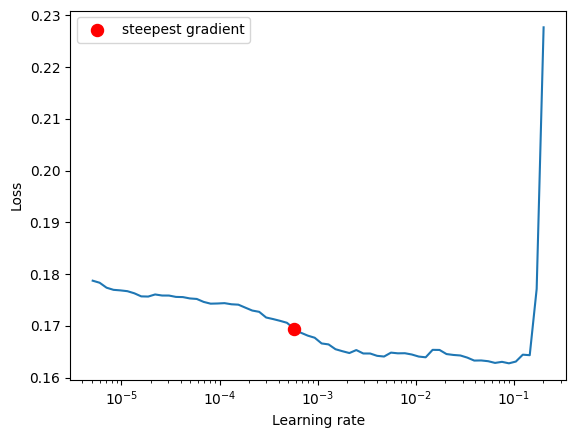

In [33]:
lr_finder.plot()  
plt.show()

In [35]:
model = BassetBranched(linear_dropout_p=0.11625456877954289,
                      branched_activation='ReLU', branched_channels=140,
                      branched_dropout_p=0.5757068086404574, 
                       n_outputs=len(train_dataset[0][1]),
                      n_linear_layers=1, n_branched_layers=3, use_batch_norm=True,
                      loss_criterion=L1KLmixed(beta=5.0, reduction='mean'))
seq_model = CNNTransferLearning(model = model,
                                lr = 5.72e-04, weight_decay = 0.01,
    parent_weights = "gs://tewhey-public-data/CODA_resources/my-model.epoch_5-step_19885.pkl",
                       frozen_epochs = 0,
                          optimizer = "AdamW",
                          scheduler="OneCycleLR",
                          scheduler_interval="step")

callback_topmodel = pl.callbacks.ModelCheckpoint(monitor="prediction_mean_pearson",
                                                 save_top_k=1,
                                                 dirpath="./Malinois",
                                                 filename="Malinois_max",
                                                mode = "max")
callback_es = pl.callbacks.early_stopping.EarlyStopping(monitor='prediction_mean_pearson', 
                                                        patience=30)

logger = pl_loggers.TensorBoardLogger("./logs_Malinois", name = "Malinois_after_lr_finder(5.72e-04)")

# Initialize a trainer
trainer = pl.Trainer(
    accelerator='gpu', 
    devices=[0], 
    min_epochs=60, 
    max_epochs=200,
    precision=16,
    enable_progress_bar = False,
    callbacks=[
        #TQDMProgressBar(refresh_rate=50), 
        callback_es, 
        #callback_topmodel
    ],
    #logger = logger
)

/home/nios/miniconda3/envs/mpra/lib/python3.12/site-packages/lightning/fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
print(train_dataset)